In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import math
import json

import psycopg2 as psql
from psycopg2.extras import RealDictCursor
from statsmodels.nonparametric.kde import KDEUnivariate

import sys
sys.path.append("..")
from tools.flight_projection import *

import seaborn as sns
sns.set(color_codes=True)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/victor/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

cnt = 0

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT cte, ate, tte, time_proj FROM public.projected_flights limit 5000;")

<h2>Distribution of Track Errors over time</h2>
Based on the collection of nominal projections, the Cross-Track error at a specified look-ahead time are aggregated and plotted

In [3]:
# create bin dataframe
la_time = 1200
bin_sec = 20
bin_dp_df = {}
fetch_batch_size = 1000
spd_lim = 30000

while True:
    
    batch = cur_read.fetchmany(size=fetch_batch_size)
    
    if not batch:
        break
    
    for f in batch:
        
        cte_lst = f['cte']
        ate_lst = f['ate']
        tte_lst = f['tte']
        ts_lst = f['time_proj']
            
        for b in range(int(la_time/bin_sec)):
            bmin = b*bin_sec
            bmax = (b+1)*bin_sec
            if str(bmax)+'_cte' not in list(bin_dp_df.keys()):
                bin_dp_df[str(bmax)+'_cte'] = []
            if str(bmax)+'_ate' not in list(bin_dp_df.keys()):
                bin_dp_df[str(bmax)+'_ate'] = []
            if str(bmax)+'_tte' not in list(bin_dp_df.keys()):
                bin_dp_df[str(bmax)+'_tte'] = []
                
            bin_dp_df[str(bmax)+'_cte'].extend([e for e,t in zip(cte_lst, ts_lst) if t >= bmin and t <= bmax and abs(e) < bmax*spd_lim])
            bin_dp_df[str(bmax)+'_ate'].extend([e for e,t in zip(ate_lst, ts_lst) if t >= bmin and t <= bmax and abs(e) < bmax*spd_lim]) 
            bin_dp_df[str(bmax)+'_tte'].extend([e for e,t in zip(tte_lst, ts_lst) if t >= bmin and t <= bmax and abs(e) < bmax*spd_lim]) 
        
cur_read.close()
conn.close()

box_data = []

bin_df = bin_dp_df #set type of error (cp or d)

for k in bin_df.keys():
    if '_cte' in k:
        box_data.append((int(k.strip('_cte')), [i for i in bin_df[k] if not np.isnan(i)]))
    
box_data_sort = sorted(box_data, key=lambda tup: tup[0])
box_data_2 = [i[1] for i in box_data_sort]

x = range(len(box_data_2))


<h2>MC Simulation & Distribution fitting</h2>
Now we fit a second degree polynomial model of the distribution parameters to the look-ahead time.
This we will use for the MC simulations in the probabilistic projection case


In [ ]:
cte_param_dict, cte_clf_dict = get_distribution_params('_cte', bin_df)
ate_param_dict, ate_clf_dict = get_distribution_params('_ate', bin_df)

# plt.scatter(x_la, cte_clf_dict[param].predict(x_in), color='r')
# plt.scatter(x_la,cte_param_dict[param])
# plt.show()

In [ ]:
la_t = 160
x_obs = [x for x in bin_df['%d_ate' % la_t] if ~np.isnan(x)]
plot_est_distr(la_t, x_obs, ate_clf_dict)

x_obs = [x for x in bin_df['%d_cte' % la_t] if ~np.isnan(x)]
plot_est_distr(la_t, x_obs, cte_clf_dict)

<h2>Sample A/C distance distribution</h2>

In [11]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT * FROM public.conflicts limit 1;")
batch = cur_read.fetchall()

cfl_dst = 9260
for b in batch:

    try:
        b = realign_conflict(b)
    except Exception as e:
        print('Error in realigning Conflict')
        b = None
        
    if b:
        b['ettc'] = []
        b['ttc'] = []
        b['ecpa'] = []

        fl1 = pd.DataFrame()
        fl1['lat'] = b['lat_1']
        fl1['lon'] = b['lon_1']
        fl1['ts'] = b['ts_1']
        fl1['hdg'] = b['hdg_1']
        fl1['spd'] = b['spd_1']

        fl2 = pd.DataFrame()
        fl2['lat'] = b['lat_2']
        fl2['lon'] = b['lon_2']
        fl2['ts'] = b['ts_2']
        fl2['hdg'] = b['hdg_2']
        fl2['spd'] = b['spd_2']


        for t in range(len(b['ts_1'])):
            try:
                ttc_i = b['ts_1'][-1] - b['ts_1'][t]
                b['ttc'].append(ttc_i)
            except:
                print(b)
                
                
            print(ttc_i)
            cte_a_est_i = cte_clf_dict['alpha'].predict([[1,ttc_i,ttc_i**2]])
            cte_b_est_i = cte_clf_dict['beta'].predict([[1,ttc_i,ttc_i**2]])
            cte_distr = pm.Cauchy.dist(alpha=cte_a_est_i, beta=cte_b_est_i)
            
            ate_a_est_i = ate_clf_dict['alpha'].predict([[1,ttc_i,ttc_i**2]])
            ate_b_est_i = ate_clf_dict['beta'].predict([[1,ttc_i,ttc_i**2]])
            ate_distr = pm.Cauchy.dist(alpha=ate_a_est_i, beta=ate_b_est_i)
            
            draw_list = []
            
            for ti in [tt for tt in range(int(ttc_i)-60,int(ttc_i)+60) if tt > 0]:
                te_dist = [(cte_distr.random(size=1),ate_distr.random(size=1)) for i in range(0,100)]
                draws = [ac_dist_stoch(ti, cte, ate, fl1['lat'][t], fl1['lon'][t], fl2['lat'][t], fl2['lon'][t], 
                                     fl1['hdg'][t], fl2['hdg'][t], fl1['spd'][t], fl2['spd'][t]) for (cte,ate) in te_dist]
                draw_list.append((ti,np.mean(draws)))
            
            break
#             b['ettc'].append(
        
        b['ttc_diff'] = [x-y for x,y in zip(b['ttc'],b['ettc'])]
            
            
        for tt in range(int(la_time/bin_sec)):
            bmin = tt*bin_sec
            bmax = (tt+1)*bin_sec
            if str(bmax) not in list(bin_dp_df.keys()):
                bin_dp_df[str(bmax)] = []
                
            bin_dp_df[str(bmax)].extend([e for e,t in zip(b['ttc_diff'], b['ttc']) 
                                                if t >= bmin and t <= bmax])

        plt.plot(b['ttc'], b['ettc'])
# plt.show()


277.0


NameError: name 'cte_clf_dict' is not defined

<h2>Kernel Density based Estimate of error distribution</h2>

<h3>Create list of KDE estimators</h3>

In [5]:
pdf_dict = {}

print('Creating kde estimators')
for la_ti in [i*20 for i in range(1,61)]:
    pdf_dict[str(la_ti)] = create_kde(bin_df,la_ti)

Creating kde estimators


<h3>Estimate TTC based on KDE</h3>

In [24]:
try:
    conn = psql.connect("dbname='thesisdata' user='postgres' host='localhost' password='postgres'")
except Exception as e:
    print("Unable to connect to the database.")
    print(e)

cur_read = conn.cursor(cursor_factory=RealDictCursor)
cur_read.execute("SELECT * FROM public.conflicts;")
batch = cur_read.fetchall()

cfl_dst = 9260
cnt = 0

for b in batch:

    try:
        b = realign_conflict(b)
    except Exception as e:
        print('Error in realigning Conflict')
        b = None
        
    if b:
        
        cnt = cnt + 1
        print('Flight: %d' % cnt)
        
        b['ettc'] = []
        b['ttc'] = []
        b['ecpa'] = []

        fl1 = pd.DataFrame()
        fl1['lat'] = b['lat_1']
        fl1['lon'] = b['lon_1']
        fl1['ts'] = b['ts_1']
        fl1['hdg'] = b['hdg_1']
        fl1['spd'] = b['spd_1']

        fl2 = pd.DataFrame()
        fl2['lat'] = b['lat_2']
        fl2['lon'] = b['lon_2']
        fl2['ts'] = b['ts_2']
        fl2['hdg'] = b['hdg_2']
        fl2['spd'] = b['spd_2']


        for t in range(len(b['ts_1'])):
            try:
                ttc_i = b['ts_1'][-1] - b['ts_1'][t]
                b['ttc'].append(ttc_i)
            except:
                print(b)
            
            draw_list = []
            draw_list_mean=[]
            base = 20
            
#             print(ttc_i)
            
            for ti in [tt for tt in range(int(ttc_i)-180,int(ttc_i)+180) if tt > 0]:
                
                la_t = max(int(round(ti/base)*base),20)
                
                te_dist_1 = pdf_dict[str(la_t)].resample(100).reshape(-1,2)
                te_dist_2 = pdf_dict[str(la_t)].resample(100).reshape(-1,2)
                
                te_dist = [(te_dist_1[i][0],te_dist_1[i][1],te_dist_2[i][0],te_dist_2[i][1]) 
                           for i in range(len(te_dist_1))]
                
                draws = [ac_dist_stoch(ti, cte_1,ate_1,cte_2,ate_2, fl1['lat'][t], fl1['lon'][t], 
                                       fl2['lat'][t], fl2['lon'][t], fl1['hdg'][t], fl2['hdg'][t], 
                                       fl1['spd'][t], fl2['spd'][t]) 
                         for (cte_1,ate_1,cte_2,ate_2) in te_dist]
                
                draw_list_mean.append((ti,np.mean(draws)))
                draw_list.append((ti,draws))
            
            try:
                b['ettc'].append([v[0] for v in draw_list_mean if v[1] >= cfl_dst][-1])
            except:
                b['ettc'].append(np.nan)
        
        b['ttc_diff'] = [x-y for x,y in zip(b['ttc'],b['ettc'])]
            
            
        for tt in range(int(la_time/bin_sec)):
            bmin = tt*bin_sec
            bmax = (tt+1)*bin_sec
            if str(bmax) not in list(bin_dp_df.keys()):
                bin_dp_df[str(bmax)] = []
                
            bin_dp_df[str(bmax)].extend([e for e,t in zip(b['ttc_diff'], b['ttc']) 
                                                if t >= bmin and t <= bmax])

#  plt.plot(b['ttc'], b['ettc'])
# plt.show()


Flight: 1
Flight: 2
Flight: 3
Flight: 4
Flight: 5
Flight: 6
Flight: 7
Flight: 8
Flight: 9
Flight: 10
Flight: 11
Flight: 12
Flight: 13


KeyError: '1320'

TypeError: Shape of x does not match that of z: found (279, 85) instead of (2, 2000).

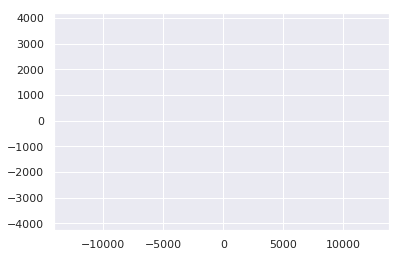

In [11]:
la_t = 200
gsize=100

cte_data_raw = [x for x in bin_df['%d_cte' % la_t] if ~np.isnan(x)]
cte_data_p = np.percentile(cte_data_raw,99)
cte_data_filt = [v for v in cte_data_raw if abs(v) < cte_data_p][:2000]
ate_data_raw = [x for x in bin_df['%d_ate' % la_t] if ~np.isnan(x)]
ate_data_p = np.percentile(ate_data_raw,99)
ate_data_filt = [v for v in ate_data_raw if abs(v) < ate_data_p][:2000]

data = np.vstack([cte_data_filt,ate_data_filt])
X,Y = np.mgrid[min(cte_data_filt):max(cte_data_filt):gsize, min(ate_data_filt):max(ate_data_filt):gsize]

dat = pdf_dict['200'].resample(2000)

fig = plt.figure()
ax = fig.gca()
ax.set_xlim(min(cte_data_filt), max(cte_data_filt))
ax.set_ylim(min(ate_data_filt), max(ate_data_filt))
# Contourf plot
cfset = ax.contourf(X, Y, dat, cmap='Blues')

In [195]:
ac_dist_stoch(190, 10, 0, fl1['lat'][t], fl1['lon'][t], fl2['lat'][t], fl2['lon'][t], 
                                     fl1['hdg'][t], fl2['hdg'][t], fl1['spd'][t], fl2['spd'][t])

-1.9594614424251757
-3.891239501402064


9218.826121582144

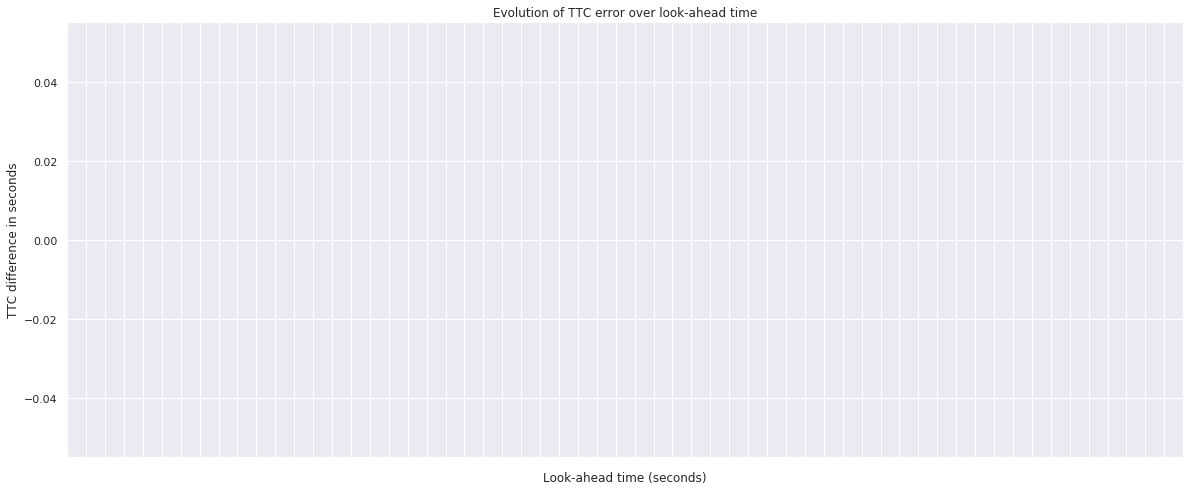

In [25]:
plt.figure(figsize=(20,8))
plt.boxplot([i[1] for i in draw_list], showfliers=False, patch_artist=True, whis=[5,95])
plt.xticks(x, [i[0] for i in draw_list])
plt.xticks(rotation=70)
plt.xlabel('Look-ahead time (seconds)')
plt.ylabel('TTC difference in seconds')
plt.title('Evolution of TTC error over look-ahead time')
plt.show()

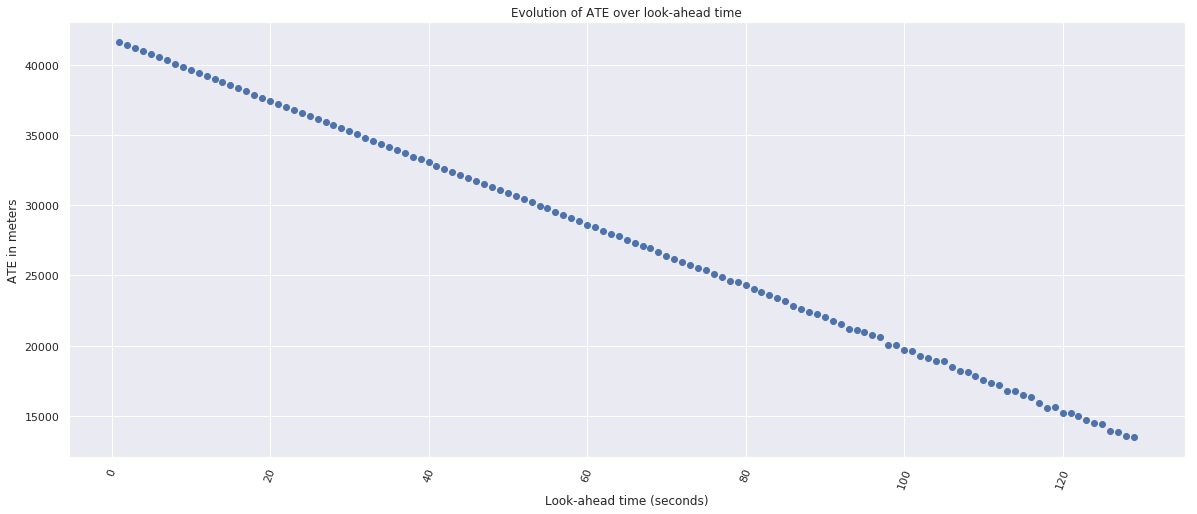

In [10]:
draw_data_sort = sorted(draw_list_mean, key=lambda tup: tup[0])
draw_data_2 = [i[1] for i in draw_list_mean]

x = range(len(draw_data_2))

plt.figure(figsize=(20,8))
# plt.scatter([i[0] for i in draw_list],[i[1] for i in draw_list])
plt.scatter([i[0] for i in draw_list_mean],[i[1] for i in draw_list_mean])
plt.xticks(rotation=70)
plt.xlabel('Look-ahead time (seconds)')
plt.ylabel('ATE in meters')
plt.title('Evolution of ATE over look-ahead time')
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
for ttc_i in [1000,200,60]:

    cte_a_est_i = cte_clf_dict['alpha'].predict([[1,ttc_i,ttc_i**2]])
    cte_b_est_i = cte_clf_dict['beta'].predict([[1,ttc_i,ttc_i**2]])
    cte_distr = pm.Cauchy.dist(alpha=cte_a_est_i, beta=cte_b_est_i)

    ate_a_est_i = ate_clf_dict['alpha'].predict([[1,ttc_i,ttc_i**2]])
    ate_b_est_i = ate_clf_dict['beta'].predict([[1,ttc_i,ttc_i**2]])
    ate_distr = pm.Cauchy.dist(alpha=ate_a_est_i, beta=ate_b_est_i)

    # te_dist = [(cte_distr.random(size=1),ate_distr.random(size=1)) for i in range(0,1000)]

    
    plt.scatter(cte_distr.random(size=50000),ate_distr.random(size=50000), alpha=0.6, s=2)
    plt.xlim(-20000,20000)
    plt.ylim(-20000,20000)

plt.show()

/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/victor/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


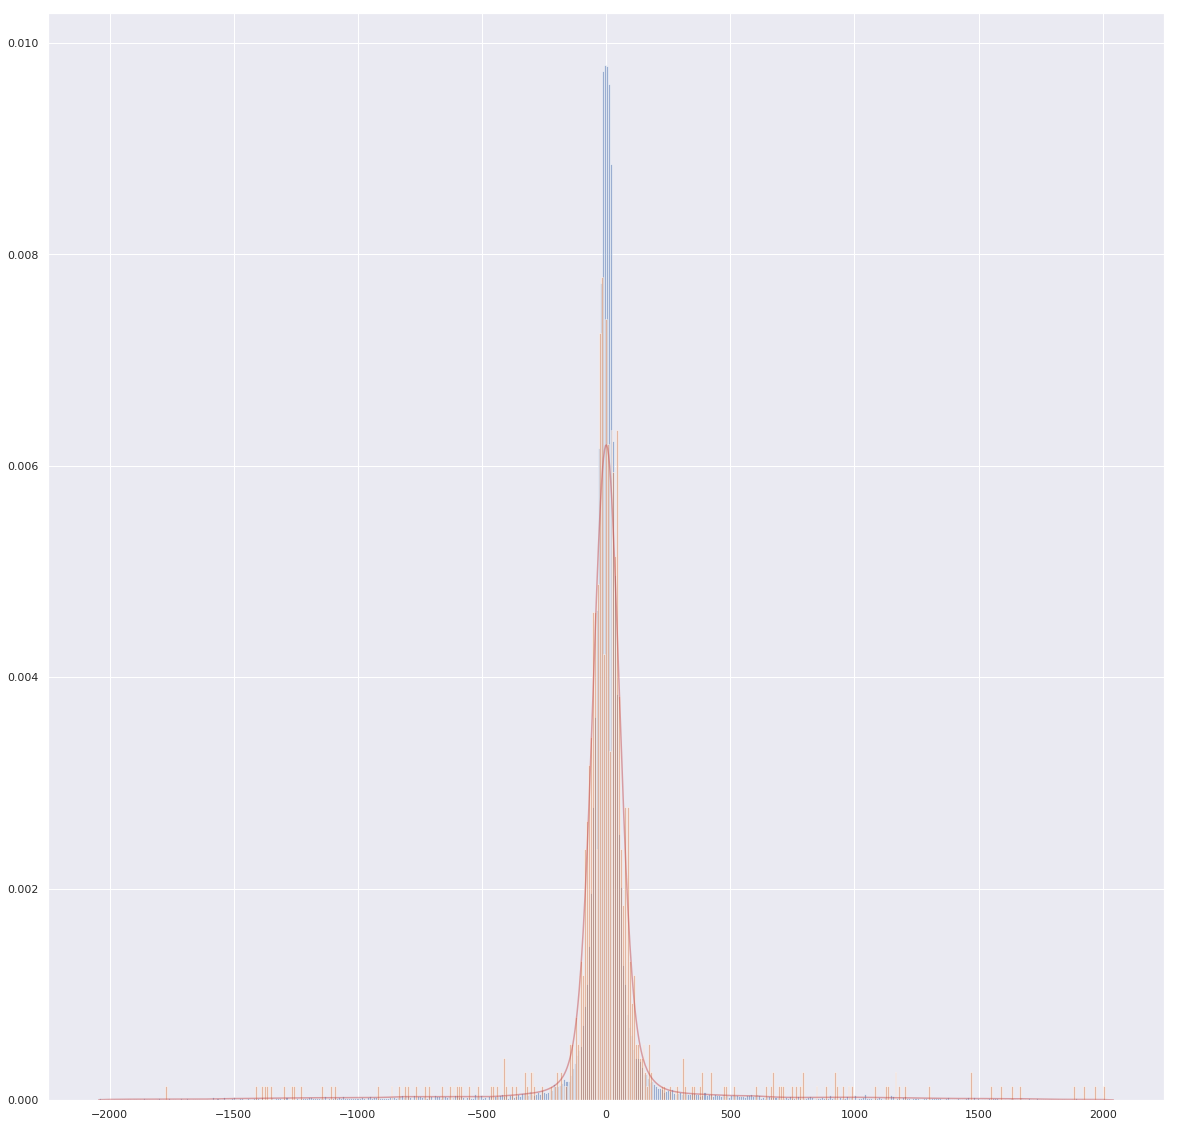

In [20]:

import time

def generate_rand_from_pdf(pdf, x_grid):
    cdf = np.cumsum(pdf)
    cdf = cdf / cdf[-1]
    values = np.random.rand(1000)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf

la_t = 60

cte_data_raw = [x for x in bin_df['%d_cte' % la_t] if ~np.isnan(x)]
cte_data_p = np.percentile(cte_data_raw,99)
ate_data_raw = [x for x in bin_df['%d_ate' % la_t] if ~np.isnan(x)]
ate_data_p = np.percentile(ate_data_raw,99)

data = [v for v in cte_data_raw if abs(v) < cte_data_p]

x_grid = np.linspace(min(data), max(data), 1000)
bandwidth = (la_t-19)
kde = gaussian_kde(data, bw_method=bandwidth / np.std(data))
kdepdf = kde.evaluate(x_grid)
random_from_kde = generate_rand_from_pdf(kdepdf, x_grid)

plt.figure(figsize=(20,20))
plt.hist(data, 500, normed=True, alpha=0.5, label='hist')
plt.hist(random_from_kde, 500, normed=True, alpha=0.5, label='hist')
plt.plot(x_grid, kdepdf, color='r', alpha=0.5, label='kde')
plt.show()

In [6]:
from scipy.stats import gaussian_kde
import time

la_t = 200

cte_data_raw = [x for x in bin_df['%d_cte' % la_t] if ~np.isnan(x)]
cte_data_p = np.percentile(cte_data_raw,99)
cte_data_filt = [v for v in cte_data_raw if abs(v) < cte_data_p][:5000]
ate_data_raw = [x for x in bin_df['%d_ate' % la_t] if ~np.isnan(x)]
ate_data_p = np.percentile(ate_data_raw,99)
ate_data_filt = [v for v in ate_data_raw if abs(v) < ate_data_p][:5000]

data = np.vstack([cte_data_filt,ate_data_filt])
X,Y = np.mgrid[min(cte_data_filt):max(cte_data_filt):400j, min(ate_data_filt):max(ate_data_filt):400j]
grid = np.vstack([Y.ravel(), X.ravel()])
kde = gaussian_kde(data, bw_method=0.1)
pdf = kde(grid)
f = np.reshape(pdf.T, X.shape)


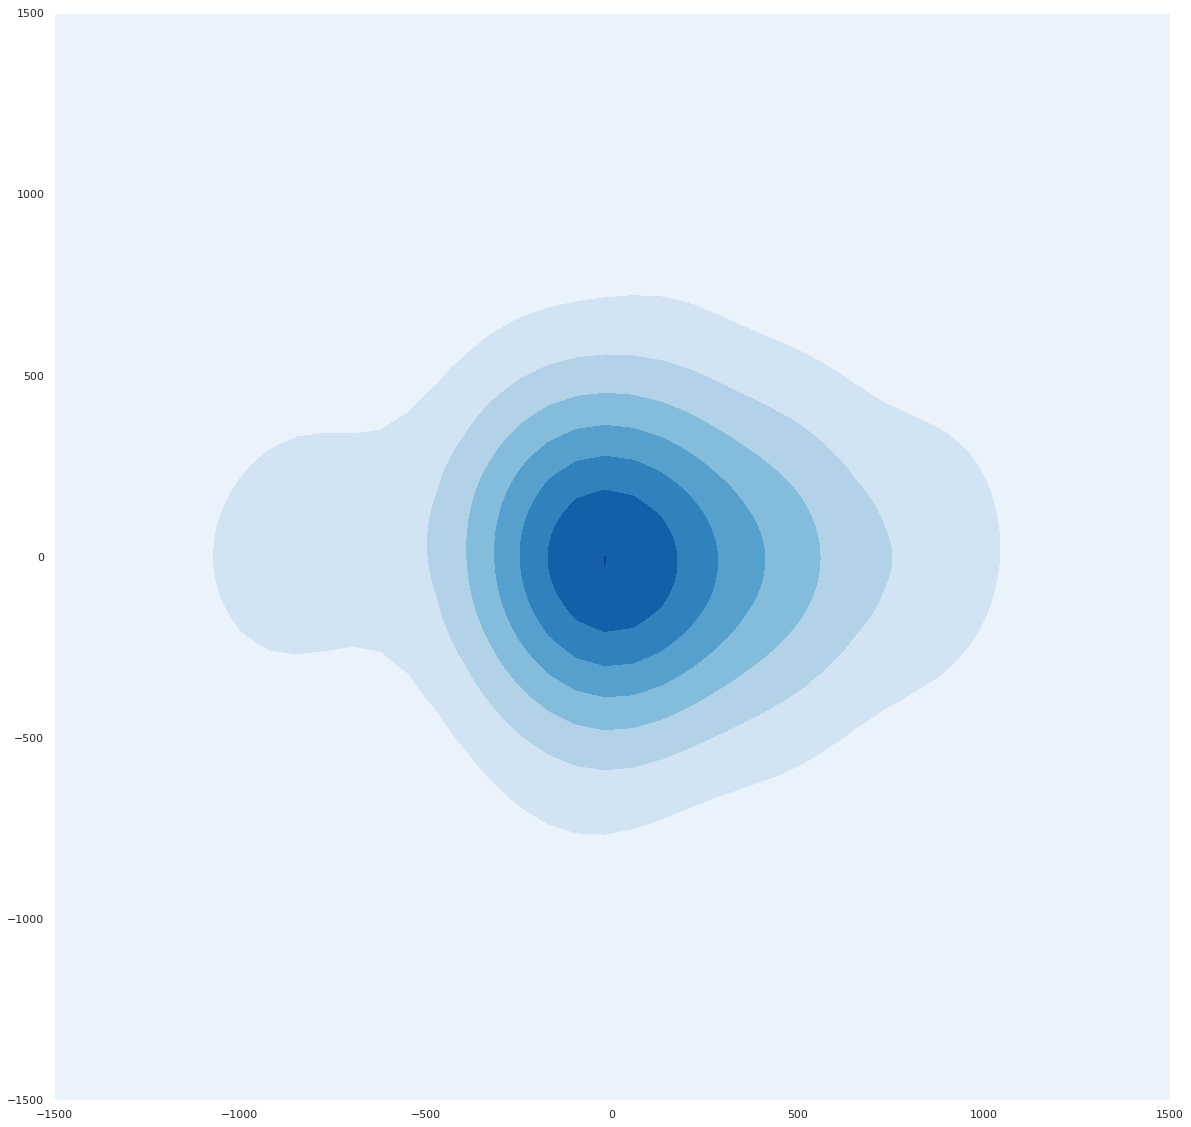

In [16]:
fig = plt.figure(figsize=(20,20))
ax = fig.gca()
ax.set_xlim(-1500, 1500)
ax.set_ylim(-1500, 1500)
# Contourf plot

cfset = ax.contourf(X, Y, f, cmap='Blues')

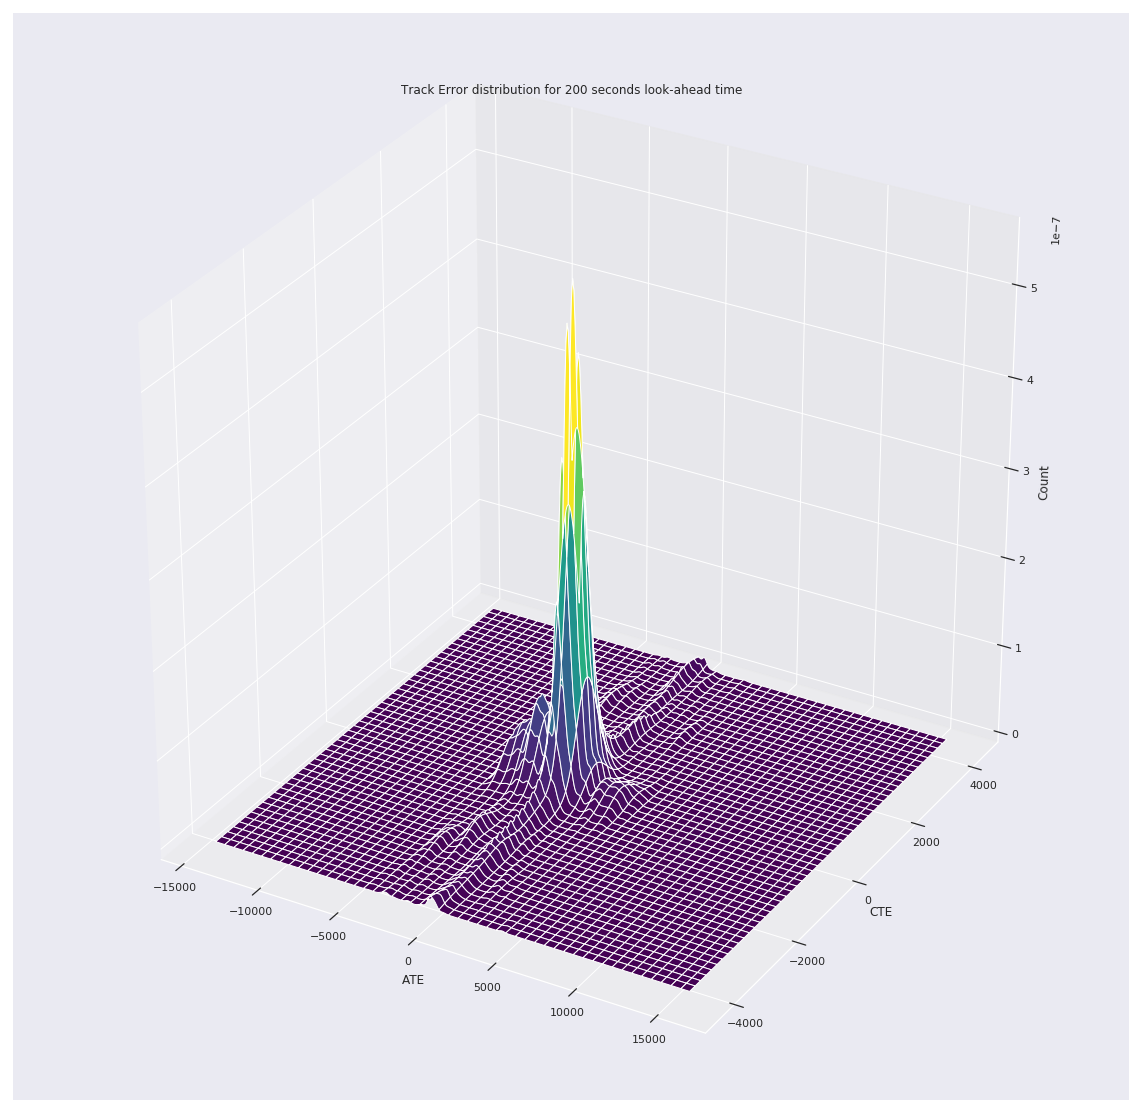

In [21]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, f, cmap=plt.cm.viridis)
ax.set_xlabel('ATE')
ax.set_ylabel('CTE')
ax.set_zlabel('Count')
ax.set_title('Track Error distribution for 200 seconds look-ahead time')
plt.show()

In [15]:
plt.show()

In [ ]:
list(zip([v for v in cte_data_raw if abs(v) < cte_data_p][:2000],[v for v in ate_data_raw if abs(v) < ate_data_p][:2000]))

In [ ]:
x_mean = []
x_std = []
x_kurt = []
x_skew = []
x_99pct = []
x_la = []

for k in bin_df.keys():
    if '_cte' in k:
        range_lim = 500000
        xtst = [x for x in bin_df[k] if ~np.isnan(x) and abs(x) < range_lim]
        std = np.nanstd(xtst)
        xmean = np.nanmean(xtst)
#         xtst = [(x-xmean)/xstd for x in xtst]
        
        x_la.append(int(k.strip('_cte')))
        x_mean.append(xmean)
        x_std.append(std)
        x_kurt.append(stats.kurtosis(xtst))
        x_skew.append(stats.skew(xtst))
        x_90pct.append(np.nanpercentile(xtst,90))

from sklearn import linear_model
import pymc3 as pm

x_in = [[1,xx,xx**2] for xx in x_la]
clf_dict = {}
param_dict = {}
param_dict['std'] = x_std
param_dict['mean'] = x_mean
param_dict['skew'] = x_skew
param_dict['skew'] = x_skew

for param in ['std','mean','skew']:
    clf_dict[param] = linear_model.LinearRegression()
    clf_dict[param].fit(x_in,param_dict[param])

    plt.scatter(x_la, clf_dict[param].predict(x_in), color='r')
    plt.scatter(x_la,param_dict[param])
    plt.show()

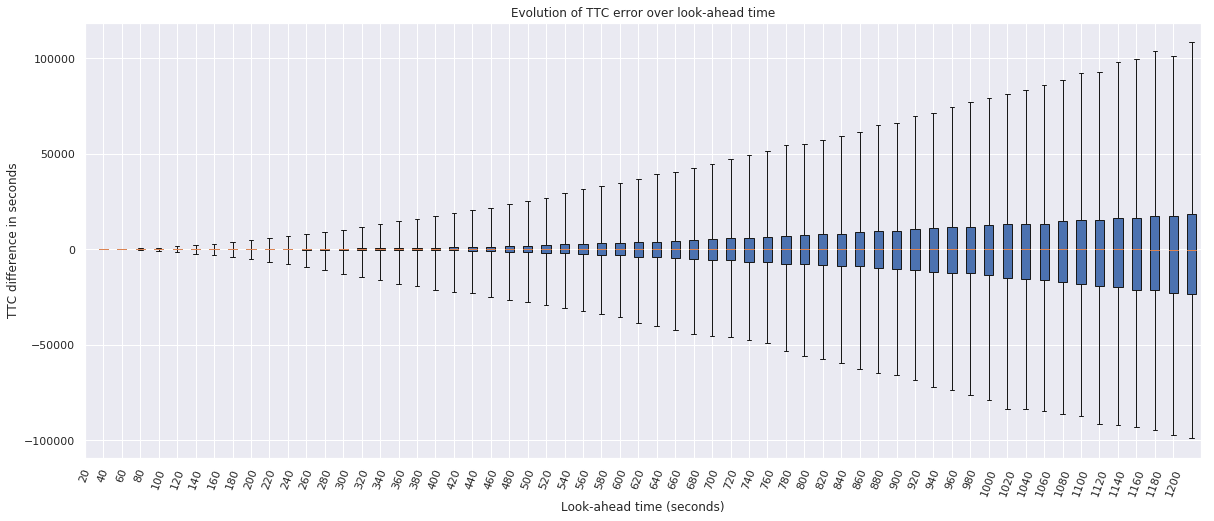

In [27]:
bin_df = bin_dp_df
box_data = []
box_data_sort = []

for k in [kx for kx in bin_df.keys() if 'cte' in kx and int(kx.strip('_cte')) <= 1200]:
    box_data.append((int(k.strip('_cte')), [i for i in bin_df[k] if not np.isnan(i)]))
    
box_data_sort = sorted(box_data, key=lambda tup: tup[0])
box_data_2 = [i[1] for i in box_data_sort]

x = range(len(box_data_2))

plt.figure(figsize=(20,8))
plt.boxplot(box_data_2, showfliers=False, patch_artist=True, whis=[5,95])
plt.xticks(x, [i[0] for i in box_data_sort])
plt.xticks(rotation=70)
plt.xlabel('Look-ahead time (seconds)')
plt.ylabel('TTC difference in seconds')
plt.title('Evolution of TTC error over look-ahead time')
plt.show()

In [29]:
len(box_data_2[20])

38507

In [1]:
cur_read.close()

conn.close()

NameError: name 'cur_read' is not defined